In [1]:
import pandas as pd
import os
import numpy as np
from Bio import SeqIO
from collections import Counter
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
# load data
braker = pd.read_csv('./GCF_002891405.2_Csec_1.0_genomic.gff', sep='\t', comment="#", header=None )

In [3]:
braker.columns = ['scaffold', 'source', 'type', 'start', 'stop', 'n', 'strand', 'n2', 'idstring']

In [4]:
tdict = {}
translate_df = pd.read_csv("GCF_002891405.2_Csec_1.0_assembly_report.txt", comment="#", sep='\t', header=None)
for i, k in translate_df.iterrows():
    tdict[k[6]]=k[4]


In [5]:
braker['scaffold2'] = [tdict[i] for i in braker.scaffold]

In [6]:
braker_genes_only = braker.loc[braker['type']=='gene']

In [10]:
#split into chunks and write them
chunk_n = 500
ss_split = np.array_split(braker_genes_only, chunk_n)

In [16]:
present_dict = { int(i.split('.')[0].split('k')[1]):True for i in os.listdir("ss_chunks_for_buff_flank") if i.endswith('.cpg')}

In [20]:
len(present_dict.keys())

500

In [ ]:
## doublecheck - 27 busted by time limit 

In [13]:
def create_and_submit_sbatch(batch, chunk):
    name="CpG_gene_batch{batch}.job".format(batch=batch)
    sbatch = [ "#!/bin/bash -l",
                    "#SBATCH -A naiss2023-22-450",
                    "#SBATCH -t 12:0:0 ",
                    "#SBATCH -p core -n 1",
                    "#SBATCH -J {name}".format(name=name),
                    "#SBATCH -o {name}_%j.out".format(name=name),
                    "#SBATCH -e {name}_%j.error".format(name=name),
                    "#SBATCH --get-user-env",
                    "##command underneath this##",
                    "conda activate base",
                    "python get_Csec_per_gene_cpg_with_buffer.py --input {chunk} --flanksize 50000 --flankbuffer 10000".format(chunk=chunk)]
    with open(name, 'wt') as handle:
        handle.write("\n".join(sbatch))
    subprocess.call(["chmod", "766", name])
    subprocess.call(["sbatch", name])

In [11]:
present_dict = { int(i.split('.')[0].split('k')[1]):True for i in os.listdir("ss_chunks_for_buff_flank") if i.endswith('.cpg')}

In [14]:
#TR_20230707_per_gene_analysis/Csec/ss_chunks_for_buff_flank
cfiles = []
for i, k in enumerate(ss_split):
    #if not i in present_dict:
        #print(i)
    chunkname = "ss_chunks_for_buff_flank/ss_chunk{chunk_i}.chunk".format(chunk_i=i)
    #k.to_csv(chunkname, sep='\t')
    create_and_submit_sbatch(batch=i, chunk=chunkname)

Submitted batch job 40114221
Submitted batch job 40114222
Submitted batch job 40114223
Submitted batch job 40114224
Submitted batch job 40114225
Submitted batch job 40114226
Submitted batch job 40114227
Submitted batch job 40114228
Submitted batch job 40114229
Submitted batch job 40114230
Submitted batch job 40114231
Submitted batch job 40114232
Submitted batch job 40114233
Submitted batch job 40114234
Submitted batch job 40114235
Submitted batch job 40114236
Submitted batch job 40114237
Submitted batch job 40114238
Submitted batch job 40114239
Submitted batch job 40114240
Submitted batch job 40114241
Submitted batch job 40114242
Submitted batch job 40114243
Submitted batch job 40114244
Submitted batch job 40114245
Submitted batch job 40114246
Submitted batch job 40114247
Submitted batch job 40114248
Submitted batch job 40114249
Submitted batch job 40114250
Submitted batch job 40114251
Submitted batch job 40114252
Submitted batch job 40114253
Submitted batch job 40114254
Submitted batc

In [ ]:
#first, create a gff file containing intron coordinates:
! module load bioinfo-tools
! module load GenomeTools/1.6.1
! gt gff3 -retainids -addintrons GCF_002891405.2_Csec_1.0_genomic.gff  > GCF_002891405.2_Csec_1.0_genomic_with_introns.gff

In [78]:
# load said file:
braker_intron = pd.read_csv('GCF_002891405.2_Csec_1.0_genomic_with_introns.gff', sep='\t', comment='#', header=None)

In [79]:
# run on genetic elements within the gene:
braker_intron.columns = ['scaffold', 'source', 'type', 'start', 'stop', 'n', 'strand', 'n2', 'idstring']
braker_intron['scaffold2'] = [tdict[i] for i in braker_intron.scaffold]

In [80]:
braker_intron_exon_only = braker_intron.loc[braker_intron['type'].isin(['exon', 'intron'])]


In [81]:
def create_and_submit_sbatch_CpG_ex_in(batch, chunk):
    name="CpG_gene_ex_in{batch}.job".format(batch=batch)
    sbatch = [ "#!/bin/bash -l",
                    "#SBATCH -A naiss2023-22-450",
                    "#SBATCH -t 2:0:0 ",
                    "#SBATCH -p core -n 1",
                    "#SBATCH -J {name}".format(name=name),
                    "#SBATCH -o {name}_%j.out".format(name=name),
                    "#SBATCH -e {name}_%j.error".format(name=name),
                    "#SBATCH --get-user-env",
                    "##command underneath this##",
                    "conda activate base",
                    "python get_Csec_per_gene_exon_intron_cpg.py --input {chunk}".format(chunk=chunk)]
    with open(name, 'wt') as handle:
        handle.write("\n".join(sbatch))
    subprocess.call(["chmod", "766", name])
    subprocess.call(["sbatch", name])

In [82]:
#split into chunks and write them
chunk_n = 50
braker_split = np.array_split(braker_intron_exon_only, chunk_n)

In [83]:
braker_split[0].head()

,scaffold,source,type,start,stop,n,strand,n2,idstring,scaffold2
3,NW_019718022.1,Gnomon,exon,753,844,.,-,.,ID=exon-XM_023849672.2-9;Parent=rna-XM_0238496...,NEVH01000001.1
5,NW_019718022.1,.,intron,845,1841,.,-,.,Parent=rna-XM_023849672.2,NEVH01000001.1
6,NW_019718022.1,Gnomon,exon,1842,2146,.,-,.,ID=exon-XM_023849672.2-8;Parent=rna-XM_0238496...,NEVH01000001.1
8,NW_019718022.1,.,intron,2147,3612,.,-,.,Parent=rna-XM_023849672.2,NEVH01000001.1
9,NW_019718022.1,Gnomon,exon,3613,3705,.,-,.,ID=exon-XM_023849672.2-7;Parent=rna-XM_0238496...,NEVH01000001.1


In [163]:
cfiles = []
for i, k in enumerate(braker_split):
    #print(i)
    chunkname = "ex_in_chunks/braker_chunk_{chunk_i}.gff3_chunk".format(chunk_i=i)
    k.to_csv(chunkname, sep='\t')
    create_and_submit_sbatch_CpG_ex_in(batch=i, chunk=chunkname)

Submitted batch job 39626708
Submitted batch job 39626709
Submitted batch job 39626711
Submitted batch job 39626713
Submitted batch job 39626715
Submitted batch job 39626717
Submitted batch job 39626720
Submitted batch job 39626721
Submitted batch job 39626722
Submitted batch job 39626723
Submitted batch job 39626724
Submitted batch job 39626725
Submitted batch job 39626726
Submitted batch job 39626727
Submitted batch job 39626729
Submitted batch job 39626731
Submitted batch job 39626732
Submitted batch job 39626733
Submitted batch job 39626734
Submitted batch job 39626735
Submitted batch job 39626736
Submitted batch job 39626737
Submitted batch job 39626738
Submitted batch job 39626739
Submitted batch job 39626740
Submitted batch job 39626741
Submitted batch job 39626742
Submitted batch job 39626743
Submitted batch job 39626744
Submitted batch job 39626745
Submitted batch job 39626746
Submitted batch job 39626747
Submitted batch job 39626748
Submitted batch job 39626749
Submitted batc

# collating the data and plotting it

In [4]:
cpg_chunks =  [ i for i in os.listdir("./ss_chunks_for_buff_flank") if i.endswith(".cpg")]
cpg_chunks = [i for i in cpg_chunks if not i.startswith('test')]
cpg_chunks_df = pd.concat([pd.read_csv(os.path.join("./ss_chunks_for_buff_flank",i), sep='\t', index_col=0) for i in cpg_chunks])
#cpg_chunks_df.to_csv('./20230717_Csec_CpG_per_gene_and_1e3flankingregions.tsv', sep='\t')

In [24]:
cpg_chunks_df

,ID,gene_cpg_e,gene_cpg_o,gene_cpg_oe,flank_u_cpg_e,flank_u_cpg_o,flank_u_cpg_oe,flank_d_cpg_e,flank_d_cpg_o,flank_d_cpg_oe
0,ID=gene-LOC111873923;Dbxref=GeneID:111873923;N...,194.596172,61,0.313470,2028.856580,821,0.404661,2481.62100,1914,0.771270
1,ID=gene-LOC117283069;Dbxref=GeneID:117283069;N...,1089.676437,960,0.880995,2029.932900,722,0.355677,2649.79330,2073,0.782325
2,ID=gene-LOC111874103;Dbxref=GeneID:111874103;N...,418.258358,172,0.411229,2366.050500,1658,0.700746,2735.46032,2356,0.861281
3,ID=gene-LOC111874115;Dbxref=GeneID:111874115;N...,3742.786792,3107,0.830130,2438.941620,1889,0.774516,2309.40160,1645,0.712306
4,ID=gene-LOC111874212;Dbxref=GeneID:111874212;N...,476.108127,166,0.348660,2637.300200,2234,0.847078,2659.60098,2187,0.822304
...,...,...,...,...,...,...,...,...,...,...
25,ID=gene-LOC111872720;Dbxref=GeneID:111872720;N...,2995.524596,1096,0.365879,32749.962022,23531,0.718505,1977.62212,803,0.406043
26,ID=gene-LOC111872723;Dbxref=GeneID:111872723;N...,520.093701,165,0.317251,1705.266420,537,0.314907,1987.39792,824,0.414612
27,ID=gene-LOC111872722;Dbxref=GeneID:111872722;N...,1561.526643,714,0.457245,1858.154400,620,0.333664,2240.24416,1755,0.783397
28,ID=gene-LOC111872725;Dbxref=GeneID:111872725;N...,6205.321026,5205,0.838796,1939.846880,833,0.429415,2289.97440,1861,0.812673


In [26]:
cpg_chunks_df.to_csv('./20230810_Csec_CpG_per_gene_and_50kbflank_10kbbuffer.tsv', sep='\t')

In [27]:
cpg_chunks_df_melt = cpg_chunks_df.melt(id_vars=['ID'], value_vars=['gene_cpg_e', 'gene_cpg_o', 'gene_cpg_oe', 'flank_u_cpg_e', 'flank_u_cpg_o','flank_u_cpg_oe','flank_d_cpg_e','flank_d_cpg_o','flank_d_cpg_oe'] )
cpg_chunks_df_melt_oe = cpg_chunks_df_melt.loc[cpg_chunks_df_melt.variable.isin(['gene_cpg_oe', 'flank_u_cpg_oe', 'flank_d_cpg_oe'])]

In [28]:
cpg_chunks_df_melt_oe['value_lim4'] = [i if i<5 else 4 for i in cpg_chunks_df_melt_oe['value']]


/scratch/ipykernel_39245/2765511403.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpg_chunks_df_melt_oe['value_lim4'] = [i if i<5 else 4 for i in cpg_chunks_df_melt_oe['value']]


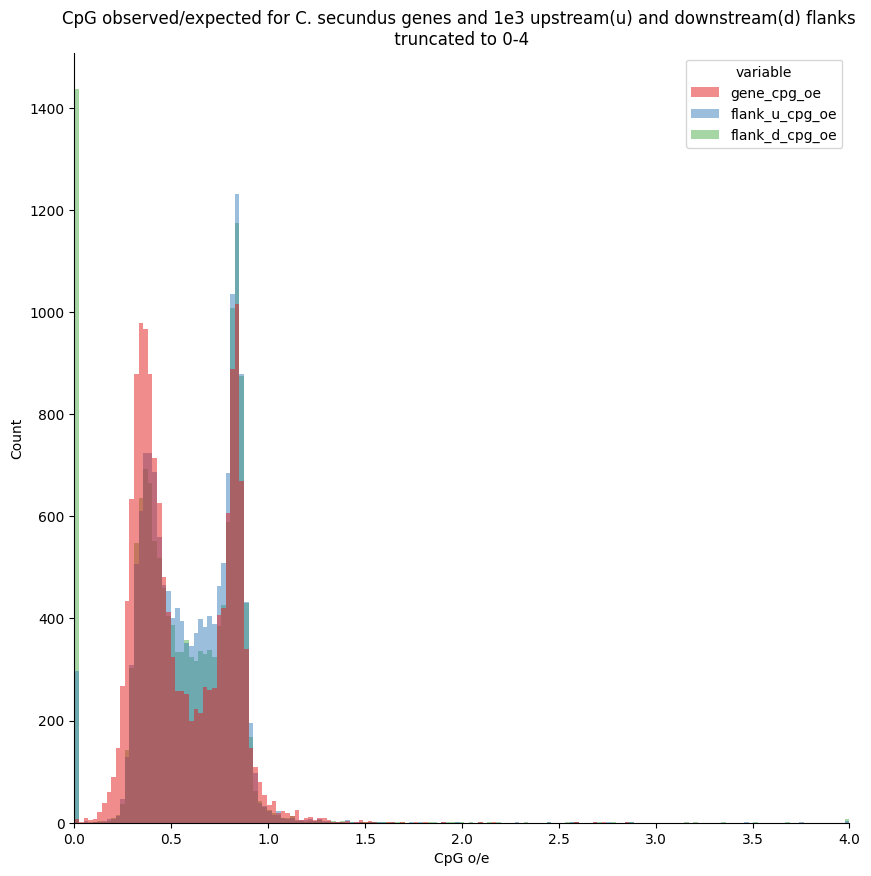

In [29]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,10))
sns.histplot(data=cpg_chunks_df_melt_oe, x="value_lim4", hue="variable",linewidth=0, binrange=[0,4], palette = ['#e41a1c','#377eb8','#4daf4a'])

ax.set_xlim(0.00,4)
#ax.set_ylim(0.00,200)
ax.set_title('CpG observed/expected for C. secundus genes and 1e3 upstream(u) and downstream(d) flanks \n truncated to 0-4 ')
ax.set_xlabel('CpG o/e')

sns.despine()
plt.show()

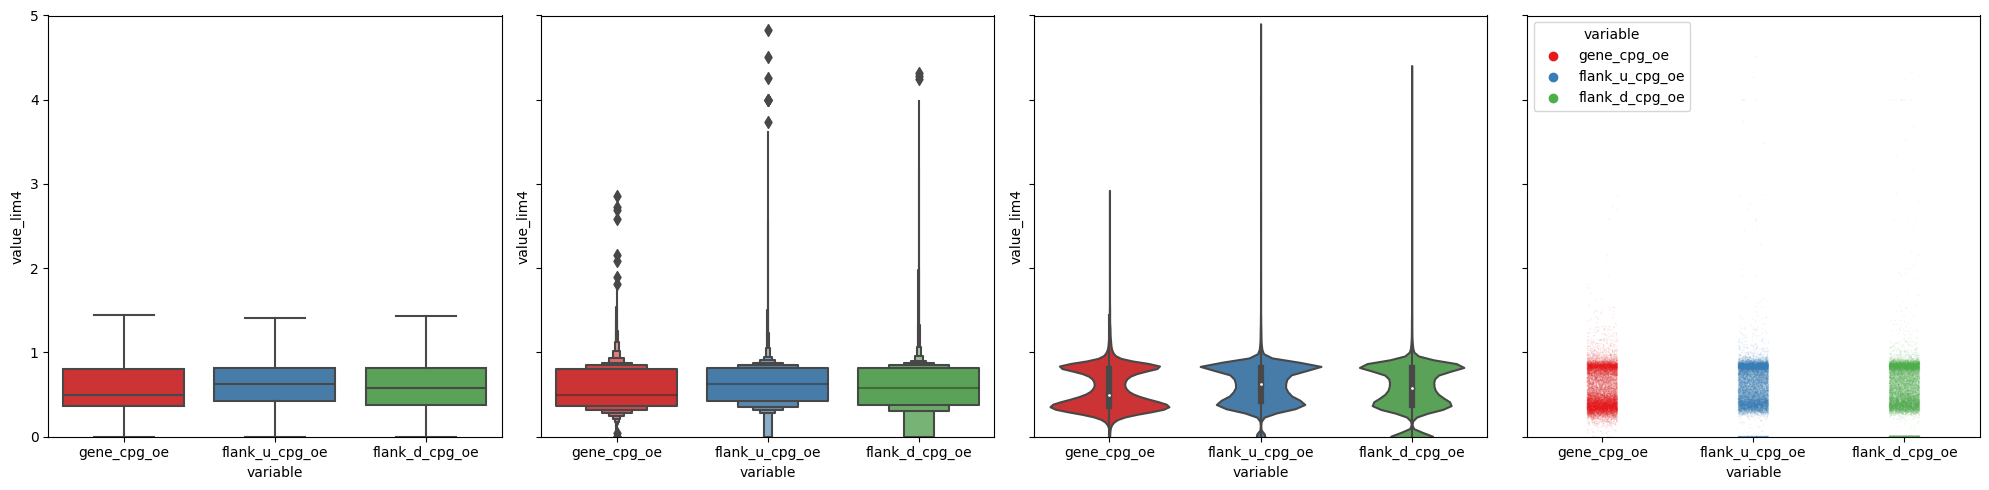

In [30]:

fig, (ax, ax1, ax2, ax3) = plt.subplots(ncols=4, nrows=1, figsize=(20,5), sharey=True, sharex=True)
sns.boxplot(data=cpg_chunks_df_melt_oe, y="value_lim4",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax, fliersize=0)
sns.boxenplot(data=cpg_chunks_df_melt_oe, y="value_lim4",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax1)
sns.violinplot(data=cpg_chunks_df_melt_oe, y="value_lim4",x='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax2)
sns.stripplot(data=cpg_chunks_df_melt_oe, y="value_lim4",x='variable', hue='variable', palette = ['#e41a1c','#377eb8','#4daf4a'], ax=ax3, alpha=0.1, s=1)


ax.set_ylim(0,5)
plt.tight_layout()
plt.show()

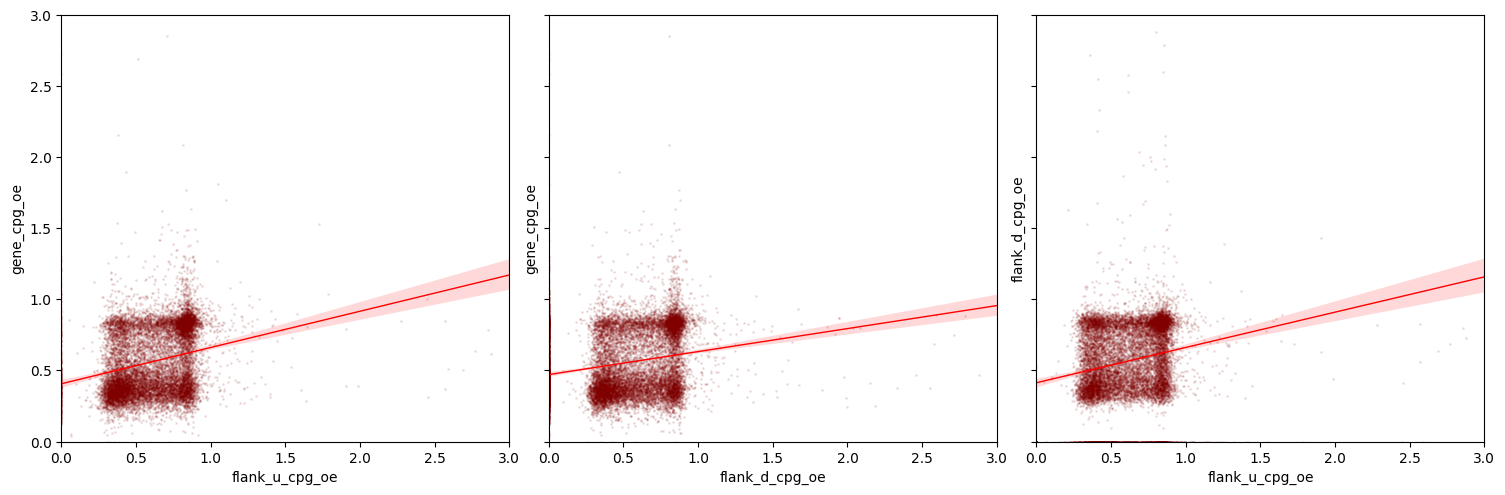

In [31]:
fig, (ax, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(15,5), sharey=True, sharex=True)

sns.regplot(data=cpg_chunks_df, x="flank_u_cpg_oe", y="gene_cpg_oe", ax=ax, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )
sns.regplot(data=cpg_chunks_df, x="flank_d_cpg_oe", y="gene_cpg_oe", ax=ax1, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )
sns.regplot(data=cpg_chunks_df, x="flank_u_cpg_oe", y="flank_d_cpg_oe", ax=ax2, line_kws={'color':'red', 'linewidth':1}, scatter_kws={'s':1, 'alpha':0.1, 'color':'maroon'} )

plt.tight_layout()
ax.set_ylim(0,3)
ax.set_xlim(0,3)

plt.show()

# exon/intron comparison

In [165]:
cpg_chunks_exin =  [ i for i in os.listdir("./ex_in_chunks/") if i.endswith("ex_in.cpg")]

In [166]:
cpg_chunks_exin = [i for i in cpg_chunks_exin if not i.startswith('test')]
cpg_chunks_exin_df = pd.concat([pd.read_csv(os.path.join("./ex_in_chunks/",i), sep='\t', index_col=0) for i in cpg_chunks_exin])
cpg_chunks_exin_df.to_csv('./20230717_Csec_CpG_exons_and_introns.tsv', sep='\t')

In [167]:
#cpg_chunks_exin_df['gene_id'] = [i.rsplit('.',1)[0] for i in cpg_chunks_exin_df.ID]
#cpg_chunks_exin_df['reg_id'] = [i.rsplit('.',1)[1] for i in cpg_chunks_exin_df.ID]

IndexError: list index out of range

NameError: name 'cpg_chunks_exin_df_onlyexin' is not defined

In [176]:
cpg_chunks_exin_df['gene_cpg_oe_lim4']  = [i if i<4 else 4 for i in cpg_chunks_exin_df['gene_cpg_oe']]

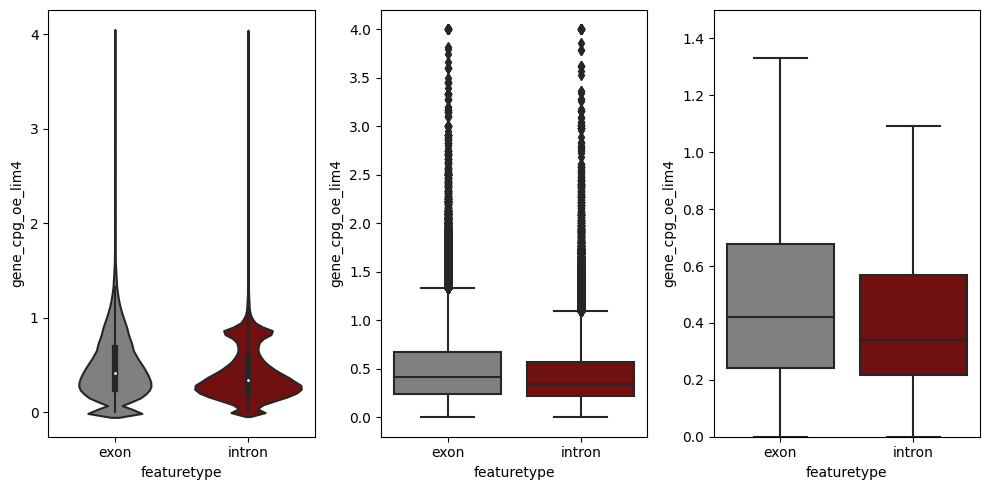

In [180]:
fig, (ax, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(10,5))

sns.violinplot(data=cpg_chunks_exin_df, x='featuretype', y='gene_cpg_oe_lim4', ax=ax, palette=['grey', 'maroon'])
sns.boxplot(data=cpg_chunks_exin_df, x='featuretype', y='gene_cpg_oe_lim4', ax=ax1,palette=['grey', 'maroon'])
sns.boxplot(data=cpg_chunks_exin_df, x='featuretype', y='gene_cpg_oe_lim4', ax=ax2, fliersize=0,palette=['grey', 'maroon'])

ax2.set_ylim(0,1.5)
plt.tight_layout()
plt.show()

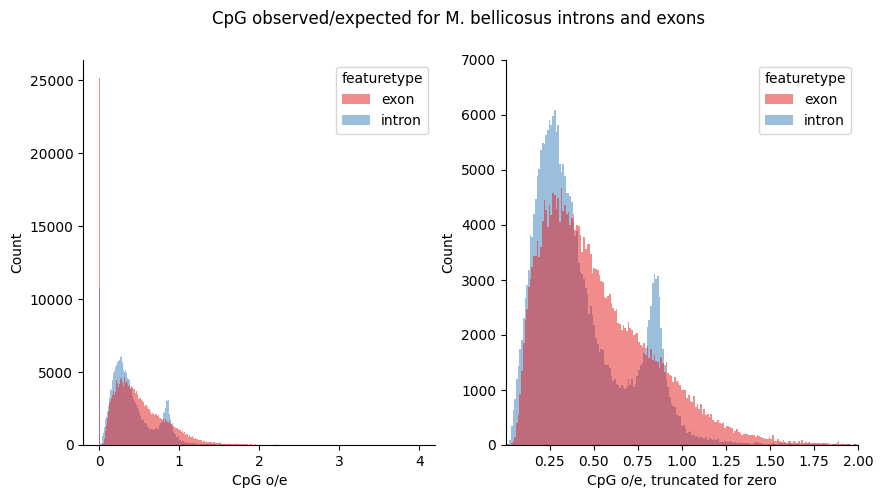

In [184]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
sns.histplot(data=cpg_chunks_exin_df, x="gene_cpg_oe_lim4", hue="featuretype",linewidth=0, palette = ['#e41a1c','#377eb8'] ,ax=ax)
#x.set_xlim(0,2)
fig.suptitle('CpG observed/expected for M. bellicosus introns and exons')
ax.set_xlabel('CpG o/e')

sns.histplot(data=cpg_chunks_exin_df, x="gene_cpg_oe_lim4", hue="featuretype",linewidth=0, palette = ['#e41a1c','#377eb8'] ,ax=ax1)
ax1.set_xlim(0.001,2)
ax1.set_ylim(0,7000)
ax1.set_xlabel('CpG o/e, truncated for zero')

sns.despine()
plt.show()

In [185]:
cpg_chunks_exin_df.groupby('featuretype')['gene_cpg_oe'].mean()

featuretype
exon      0.481619
intron    0.415801
Name: gene_cpg_oe, dtype: float64

In [186]:
cpg_chunks_exin_df.groupby('featuretype')['gene_cpg_oe'].sem()

featuretype
exon      0.000609
intron    0.000665
Name: gene_cpg_oe, dtype: float64

In [187]:
cpg_chunks_exin_df.groupby('featuretype')['gene_cpg_oe'].std()

featuretype
exon      0.339126
intron    0.349578
Name: gene_cpg_oe, dtype: float64

In [190]:
cpg_chunks_df_melt.groupby('variable')['value'].mean()

variable
flank_d_cpg_e       37.474066
flank_d_cpg_o       23.803715
flank_d_cpg_oe       0.732231
flank_u_cpg_e       37.322896
flank_u_cpg_o       23.728758
flank_u_cpg_oe       0.750432
gene_cpg_e        1867.628619
gene_cpg_o        1329.284943
gene_cpg_oe          0.562742
Name: value, dtype: float64

In [191]:
cpg_chunks_df_melt.groupby('variable')['value'].sem()

variable
flank_d_cpg_e      0.086580
flank_d_cpg_o      0.118046
flank_d_cpg_oe     0.070321
flank_u_cpg_e      0.089594
flank_u_cpg_o      0.118857
flank_u_cpg_oe     0.051395
gene_cpg_e        32.370659
gene_cpg_o        27.018363
gene_cpg_oe        0.001919
Name: value, dtype: float64

In [192]:
cpg_chunks_df_melt.groupby('variable')['value'].std()

variable
flank_d_cpg_e       10.667964
flank_d_cpg_o       14.545095
flank_d_cpg_oe       8.664658
flank_u_cpg_e       11.039397
flank_u_cpg_o       14.644947
flank_u_cpg_oe       6.332631
gene_cpg_e        3988.559169
gene_cpg_o        3329.074535
gene_cpg_oe          0.236442
Name: value, dtype: float64

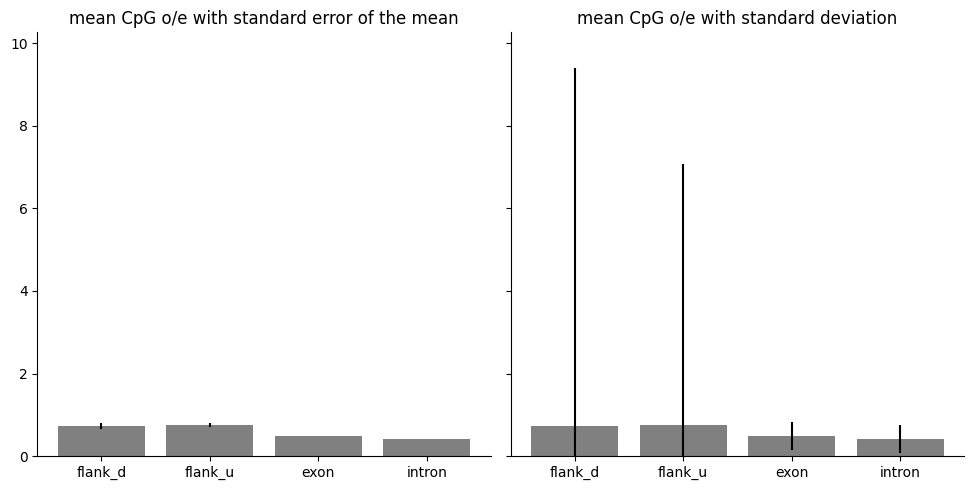

In [195]:
fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(10,5), sharey=True)
ax.bar(height = [0.732231,0.750432, 0.481619,0.415801 ], x= ['flank_d', 'flank_u', 'exon', 'intron'], yerr = [0.070321,0.051395,0.000609,0.000665], color='grey')
ax1.bar(height = [0.732231,0.750432, 0.481619,0.415801 ], x= ['flank_d', 'flank_u', 'exon', 'intron'], yerr = [8.664658,6.332631,0.339126,0.349578], color='grey')

ax.set_title("mean CpG o/e with standard error of the mean")
ax1.set_title("mean CpG o/e with standard deviation")
sns.despine()
plt.tight_layout()
ax.set_ylim(0,)
plt.show()

# get Tukeys HSD

In [197]:
fd = cpg_chunks_df_melt.loc[cpg_chunks_df_melt.variable =='flank_d_cpg_oe' ]['value']
fu = cpg_chunks_df_melt.loc[cpg_chunks_df_melt.variable =='flank_u_cpg_oe' ]['value']
ex = cpg_chunks_exin_df.loc[cpg_chunks_exin_df.featuretype =='exon']['gene_cpg_oe']
intr = cpg_chunks_exin_df.loc[cpg_chunks_exin_df.featuretype =='intron']['gene_cpg_oe']

In [198]:
thsd = scipy.stats.tukey_hsd(fd, fu, ex, intr)

In [199]:
print(thsd)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.018     0.792    -0.069     0.032
 (0 - 2)      0.251     0.000     0.214     0.287
 (0 - 3)      0.316     0.000     0.280     0.353
 (1 - 0)      0.018     0.792    -0.032     0.069
 (1 - 2)      0.269     0.000     0.232     0.305
 (1 - 3)      0.335     0.000     0.298     0.371
 (2 - 0)     -0.251     0.000    -0.287    -0.214
 (2 - 1)     -0.269     0.000    -0.305    -0.232
 (2 - 3)      0.066     0.000     0.054     0.077
 (3 - 0)     -0.316     0.000    -0.353    -0.280
 (3 - 1)     -0.335     0.000    -0.371    -0.298
 (3 - 2)     -0.066     0.000    -0.077    -0.054

